# DC2 Run1.2 object catalog footprint (Spark)
<br> Kernel: **desc-pyspark**
<br>Owner: **S Plaszczynski** (https://github.com/LSSTDESC/DC2-production/issues/299)
<br>Last Verified to Run: **2018-11-18**
    
The goal of this notebook is to have a QA look a the dc2-data-access produced object_catalog (currently on Run1.2p)
It also illustrates how simple and efficient Spark is.


## load the full Run1.2 catalog from single parquet file

In [182]:
from pyspark.sql import SparkSession

# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()
print("spark session started")

spark session started


In [230]:
object_catalog="/global/cscratch1/sd/plaszczy/Run1.2p/object_catalog/full_catalog.parquet"
df_all=spark.read.parquet(object_catalog)
df_all.printSchema()

root
 |-- magerr_g: double (nullable = true)
 |-- I_flag_g: boolean (nullable = true)
 |-- tract: long (nullable = true)
 |-- IxyPSF_y: double (nullable = true)
 |-- I_flag_y: boolean (nullable = true)
 |-- Ixx_i: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- magerr_u: double (nullable = true)
 |-- mag_z_cModel: double (nullable = true)
 |-- mag_u: double (nullable = true)
 |-- snr_g_cModel: double (nullable = true)
 |-- Ixx: double (nullable = true)
 |-- mag_u_cModel: double (nullable = true)
 |-- magerr_y: double (nullable = true)
 |-- magerr_r_cModel: double (nullable = true)
 |-- IxyPSF_r: double (nullable = true)
 |-- psFlux_y: double (nullable = true)
 |-- magerr_y_cModel: double (nullable = true)
 |-- mag_g_cModel: double (nullable = true)
 |-- Iyy_i: double (nullable = true)
 |-- I_flag_z: boolean (nullable = true)
 |-- snr_u_cModel: double (nullable = true)
 |-- Ixy_z: double (nullable = true)
 |-- psFluxErr_r: double (nullable = true)
 |-- mag_i_cModel: dou

In [184]:
#select relevant columns
df=df_all.select("tract","patch","ra","dec")
# and put them in cache
N=df.cache().count()
print("#galaxies={} millions".format(N/1e6))

#galaxies=27.083536 millions


## Look at tracts and patches

In [185]:
df.select("tract").distinct().count() #check that all the tracts are present

20

According to https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/dm_butler_skymap.ipynb This is OK. how many patches per tract?

In [186]:
df.groupBy(["tract","patch"]).count().groupBy("tract").count().\
withColumnRenamed("count","#patches").sort("tract").show()  #groupBy twice, rename and sort

+-----+--------+
|tract|#patches|
+-----+--------+
| 4429|      42|
| 4430|      56|
| 4431|      56|
| 4432|      56|
| 4433|       7|
| 4636|      16|
| 4637|      64|
| 4638|      64|
| 4639|      64|
| 4640|      48|
| 4848|      48|
| 4849|      64|
| 4850|      64|
| 4851|      64|
| 4852|      16|
| 5062|      17|
| 5063|      56|
| 5064|      56|
| 5065|      56|
| 5066|      35|
+-----+--------+



## (ra,dec) footprint

In [187]:
#are there some Nans?
import numpy as np
df.filter(df['ra'].contains(np.nan)).count()

0

No so lets do some basic statistics

In [188]:
df.describe(['ra','dec']).show()

+-------+------------------+-------------------+
|summary|                ra|                dec|
+-------+------------------+-------------------+
|  count|          27083536|           27083536|
|   mean| 55.07338013097766| -29.79419390003542|
| stddev|1.9014363884446157|  1.643124412278626|
|    min| 51.74916962374651| -32.58858724482577|
|    max| 58.36818361208815|-26.947017635210035|
+-------+------------------+-------------------+



We will project galaxies in a Healpix map. For that we define a pandas User Defined Function to call healpy ang2pix function

In [189]:
import pandas as pd
import numpy as np
import healpy as hp
from pyspark.sql.functions import pandas_udf, PandasUDFType

nside=4096
#create the ang2pix user-defined-function. 
#we use pandas_udf because they are more efficient
@pandas_udf('int', PandasUDFType.SCALAR)
def Ang2Pix(ra,dec):
    return pd.Series(hp.ang2pix(nside,np.radians(90-dec),np.radians(ra)))

In [190]:
#add a column of healpix indices
df=df.withColumn("ipix",Ang2Pix("ra","dec"))
#groupby indices and count the number of elements in each group
df_map=df.groupBy("ipix").count()
#statistics per pixel
df_map.describe(['count']).show() 

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|           151697|
|   mean|178.5370574236801|
| stddev| 57.0695610931771|
|    min|                1|
|    max|              453|
+-------+-----------------+



In [191]:
#back to python world
map_p=df_map.toPandas()

In [192]:
#now data is reduced create the healpy map
map = np.zeros(hp.nside2npix(nside))
map[map_p['ipix'].values]=map_p['count'].values
map[map==0]=hp.UNSEEN

<Figure size 432x288 with 0 Axes>

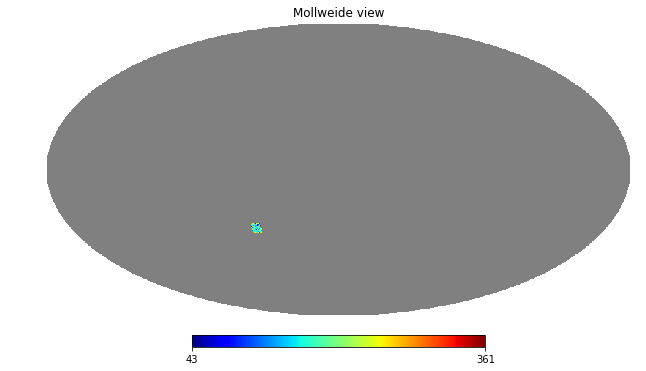

In [193]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap('jet') #color-blind people should comment this line

hp.mollview(map)

from the previous mean ra/dec and count statistics we can zoom on the center and perform a gnomonic projection

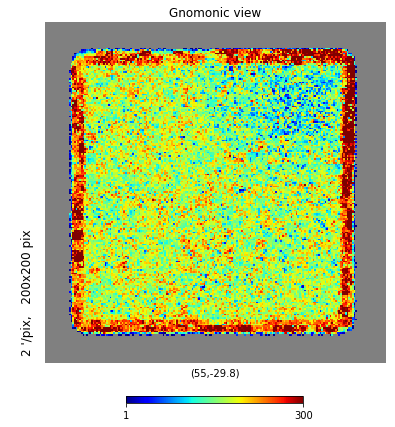

In [194]:
hp.gnomview(map,rot=[55,-29.8],reso=2,max=300)


## Plotting tracts outline

Let's try to draw the tracts borders. This should be done with the Butler but impossible since it
runs in a dedicated shifter image.
So we do it the (not quick ) & dirty way assuming square tracts by identifying the min/max ra/dec values per tract.
This is slighly evolved (and boring) so Spark newbies may prefer to switch directly to the plot.


In [197]:
#get minmax(ra,dec) for each tract
from pyspark.sql import functions as F
df_borders=df.select("tract","ra","dec").groupBy("tract").agg(F.min("ra"),F.max("ra"),F.min("dec"),F.max("dec"))
df_borders.show(5)
borders=df_borders.toPandas() #now it is reduced get back to pandas

+-----+------------------+------------------+-------------------+-------------------+
|tract|           min(ra)|           max(ra)|           min(dec)|           max(dec)|
+-----+------------------+------------------+-------------------+-------------------+
| 4848| 51.84118317998846| 52.99065281554606|-29.752065967931784| -28.26446294804096|
| 4636| 51.78278941840307|52.037913192917955| -31.23966928590609|-29.752073874629247|
| 4639| 55.45023716177039| 57.15639746864757|  -31.2396693180903| -29.75206649894015|
| 5065| 55.57603789304723| 57.23502286597086|-28.264462046344953|-26.963809311641512|
| 5064|53.917050778148365|   55.576036808009|-28.264462762402683| -26.96995988024382|
+-----+------------------+------------------+-------------------+-------------------+
only showing top 5 rows



In [198]:
#create a dictionary to access easily the limits from the tract number
d=dict()
for p in borders.values:
    d[str(p[0].astype('int'))]=(p[1],p[2],p[3],p[4])

#create external UDFs based on it
@pandas_udf('float', PandasUDFType.SCALAR)  
def min_ra(tracts):
    return pd.Series([d[str(t)][0] for t in tracts])
@pandas_udf('float', PandasUDFType.SCALAR)  
def max_ra(tracts):
    return pd.Series([d[str(t)][1] for t in tracts])
@pandas_udf('float', PandasUDFType.SCALAR)  
def min_dec(tracts):
    return pd.Series([d[str(t)][2] for t in tracts])
@pandas_udf('float', PandasUDFType.SCALAR)  
def max_dec(tracts):
    return pd.Series([d[str(t)][3] for t in tracts])

In [199]:
#add the columns of limits to the full df
dfb=df.drop("patch")\
    .withColumn("min(ra)",min_ra(df.tract))\
    .withColumn("max(ra)",max_ra(df.tract))\
    .withColumn("min(dec)",min_dec(df.tract))\
    .withColumn("max(dec)",max_dec(df.tract))
dfb.cache().count() #cache for further computations
dfb.show(5)

+-----+------------------+-------------------+---------+---------+--------+----------+----------+
|tract|                ra|                dec|     ipix|  min(ra)| max(ra)|  min(dec)|  max(dec)|
+-----+------------------+-------------------+---------+---------+--------+----------+----------+
| 5063|  53.8663614535517|-28.264400769164855|148334995|52.258068|53.91705|-28.264463|-26.947018|
| 5063| 53.87384889185406|-28.264221159859375|148318612|52.258068|53.91705|-28.264463|-26.947018|
| 5063|53.839287129441665|-28.264037055358912|148318610|52.258068|53.91705|-28.264463|-26.947018|
| 5063|53.893097776428114| -28.26337181562459|148318613|52.258068|53.91705|-28.264463|-26.947018|
| 5063| 53.81825505899748|-28.263722297682882|148334993|52.258068|53.91705|-28.264463|-26.947018|
+-----+------------------+-------------------+---------+---------+--------+----------+----------+
only showing top 5 rows



In [153]:
# does not work, a pity...
#df.withColumn("min(ra)",F.lit(df_borders.filter(df_borders.tract==df.tract).first()['min(ra)'])).show()

In [228]:
epsilon=0.01
df_pix=dfb.filter((dfb["ra"]<dfb['min(ra)']+epsilon) | \
           (dfb["ra"]>dfb['max(ra)']-epsilon) | \
           (dfb["dec"]<dfb['min(dec)']+epsilon) | \
           (dfb["dec"]>dfb['max(dec)']-epsilon))\
        .select("ipix").distinct()
df_pix.count()

7238

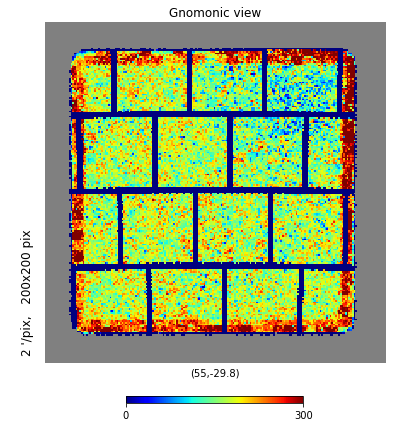

In [229]:
map_t=map
map_t[df_pix.toPandas().values]=0
hp.gnomview(map_t,rot=[55,-29.8],reso=2,max=300)

## Hot spots

Let's focuss on the 2 (or 3?) hot spots belonging to tract=4640
cccording to https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/dm_butler_skymap.ipynb 

In [207]:
t=df.filter(df.tract==4640).groupBy("patch").count()

In [208]:
t.show(5)

+-----+-----+
|patch|count|
+-----+-----+
|  4,3|37800|
|  3,1|68666|
|  2,6|  140|
|  2,7|  203|
|  3,2|47241|
+-----+-----+
only showing top 5 rows



we go back to the standard python world and create a dictionary of occupancy per patch 

In [209]:
occ=dict(t.toPandas().values)

then fill a 8x8 matrix from these to see which patches are missing

In [210]:
import numpy as np
mat=np.zeros([8,8],'int')
for k in occ.keys():
    counts=occ[k]
    i=int(k[0])
    j=int(k[2])
    mat[i,j]=counts

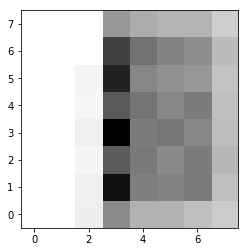

In [213]:
plt.imshow(mat.transpose(),origin='lower',cmap='binary')

Loks like the hot-spots corresponds to **patches=3,1/3,3/4,5**